In [1]:
# Import necessary libraries
import pandas as pd
import numpy as np 
import matplotlib.pyplot as plt
import seaborn as sns 
from functools import reduce
from scipy import stats
import statsmodels.api as sm
from sklearn.preprocessing import MinMaxScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from kneed import KneeLocator
import warnings

warnings.filterwarnings('ignore')
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
plt.style.use('fivethirtyeight')

In [2]:
# Read all csv files into dataframes
vertical = pd.read_csv(r"C:\Users\sychev.6\Downloads\DA_Take_Home_Assignment\data\data_vertical.csv")
segment = pd.read_csv(r"C:\Users\sychev.6\Downloads\DA_Take_Home_Assignment\data\data_business_segments.csv")
level = pd.read_csv(r"C:\Users\sychev.6\Downloads\DA_Take_Home_Assignment\data\data_integrations.csv")
country = pd.read_csv(r"C:\Users\sychev.6\Downloads\DA_Take_Home_Assignment\data\data_countries.csv")
orders = pd.read_csv(r"C:\Users\sychev.6\Downloads\DA_Take_Home_Assignment\data\data_orders.csv")
operations = pd.read_csv(r"C:\Users\sychev.6\Downloads\DA_Take_Home_Assignment\data\data_operations.csv")
finance = pd.read_csv(r"C:\Users\sychev.6\Downloads\DA_Take_Home_Assignment\data\data_finance.csv")

**First step** is to merge all dataframes with metrics and group by partner id to get total result of observed week and necessary structure one row per each partner.

In [3]:
# Checking size of dataframes for the merging purposes
orders.shape[0] == operations.shape[0] == finance.shape[0]

True

In [4]:
# Compile the list of dataframes with metrics to merge
data_frames = [orders, operations, finance]

# Merge all dataframes in the list together on partner_id and date
metrics = reduce(lambda  left,right: pd.merge(left, right, on=['date','partner_id'], how='outer'), data_frames)

In [5]:
# Custom function to calculate weighted average for delivery_time, preparation_time, order_cost and order_revenue
wm = lambda x: np.average(x, weights=metrics.loc[x.index, "orders_daily"])

# Group and aggregate combined dataset 
metrics_grouped = metrics.groupby(['partner_id'], as_index=False).agg({'orders_daily':'sum', 
                                                                       'connected_hours':'sum', 
                                                                       'avg_delivery_time_min':wm, 
                                                                       'avg_preparation_time_min':wm,
                                                                       'avg_order_cost':wm,
                                                                       'avg_order_revenue':wm
                                                                        }).rename(columns={'orders_daily':'orders_weekly'})
# Briefly review of grouped dataframe
metrics_grouped.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 46208 entries, 0 to 46207
Data columns (total 7 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   partner_id                46208 non-null  int64  
 1   orders_weekly             46208 non-null  float64
 2   connected_hours           46208 non-null  int64  
 3   avg_delivery_time_min     46208 non-null  float64
 4   avg_preparation_time_min  46208 non-null  float64
 5   avg_order_cost            46208 non-null  float64
 6   avg_order_revenue         46208 non-null  float64
dtypes: float64(5), int64(2)
memory usage: 2.8 MB


In [6]:
# Checking size of dataframes for the merging purposes
vertical.shape[0] == segment.shape[0] == level.shape[0] == country.shape[0] == metrics_grouped.shape[0]

True

**Second step** is to join all dimesions and metrics together to end up with dataset containing one row per partner with all the dimensions and metrics as columns.

In [7]:
# Compile the dimension dataframes with metrics
dfs = [vertical, segment, level, country, metrics_grouped]

# Merge all dataframes in the list together on partner_id
partners = reduce(lambda  left,right: pd.merge(left, right, on=['partner_id'], how='outer'), dfs)

# First 5 rows of dataset
print(partners.head())
print('-'*100,'\n')

# Null values, dtypes, entries per column
print(partners.info())
print('-'*100,'\n')

# Summary statistic
print(partners.describe())
print('-'*100,'\n')

# Check duplicated records
print("If any duplicates in dataset? Answer: {}".format(partners.duplicated().any()))

   partner_id vertical business_segment  is_integrated country  orders_weekly  \
0      169385     Food       Local Hero          False      ES            2.0   
1      230660     Food        Long Tail          False      PT           49.0   
2      247635     Food            Chain           True      ES           23.0   
3      341110     Food            Chain          False      ES           25.0   
4      368335     Food        Long Tail          False      ES           36.0   

   connected_hours  avg_delivery_time_min  avg_preparation_time_min  \
0               18              21.933333                 13.095000   
1                4              27.863265                  9.014281   
2                0              33.005072                 18.019130   
3               36              33.342000                 10.775067   
4               58              34.642130                 11.068542   

   avg_order_cost  avg_order_revenue  
0        5.985465          13.153395  
1       

Thus we have clean and well prepared dataset with no missing values or duplicated records and with correct structure of entries for further exploration and deriving insights.

#  **Task 1**

**1. How many active partners do we have in our dataset?**

Since all partner_ids are unique to answer the question simply caculate the number of all records in a dataset.

In [8]:
# Count nuber of unique values in 'partner_id' column
active_partners = partners['partner_id'].nunique()

# Print result
print("Number of active users in dataset: ",active_partners)

Number of active users in dataset:  46208


**2. What is the breakdown per country? And per business segment?**

To answer this question calculate number of records per each **country** and **business_segment** using *value_count* method and display results in real numbers and percentages.

In [9]:
# Count amount of each unique value in 'country' column in numbers and percentages and concat the result together
breakdown_per_country = pd.concat([partners["country"].value_counts(), 
                                   partners["country"].value_counts(normalize=True).mul(100).round(2)],axis=1, 
                                   keys=('Counts','Percentage'))

# Count amount of each unique value in 'business_segment' column in numbers and percentages and concat the result together
breakdown_per_segment = pd.concat([partners["business_segment"].value_counts(), 
                                   partners["business_segment"].value_counts(normalize=True).mul(100).round(2)],axis=1, 
                                   keys=('Counts','Percentage'))

# Print result
print("Breakdown per country:",'\n'*2,breakdown_per_country)
print('\n',"-"*30,'\n')
print("Breakdown per business segment:",'\n'*2,breakdown_per_segment)

Breakdown per country: 

     Counts  Percentage
ES   22183       48.01
IT   10840       23.46
UA    6808       14.73
PT    6377       13.80

 ------------------------------ 

Breakdown per business segment: 

             Counts  Percentage
Long Tail    21273       46.04
Chain         7529       16.29
Q-Commerce    7110       15.39
Local Hero    5475       11.85
Big Chain     3730        8.07
Sidekick      1089        2.36


**3. What percentage of partners have delivered 80% of the orders?**

To find the answer follow such logic: 
 - calculate the sum of all orders;
 - define 80% threshold from the total amount;
 - sort orders descendingly to get biggest numbers on the top;
 - using 'cumsum' method go through the rows and keep indices of partners with biggest orders amount;
 - get number of partners with biggets orders by filtering with saved indices;
 - divide number of biggest partners by total amount of partners and multiply by 100 to get percentage

In [10]:
# Define threshold for filtering
thresh = 0.8 * partners['orders_weekly'].sum()

# Sort values descendingly for top orders
orders_weekly = partners['orders_weekly'].sort_values(ascending=False).reset_index(drop=True)

# Store indices of those with cumsum pass threshold
order_pass_thresh = orders_weekly.index[orders_weekly.cumsum().ge(thresh)]

# Get amount of partners with more orders than others
n_80_percentage = order_pass_thresh[0] + 1

# Print results
print("Percentage of partners have delivered 80% of the orders is", round(n_80_percentage/partners.shape[0]*100,2),"%")

Percentage of partners have delivered 80% of the orders is 21.37 %


This observation proofs well known **Pareto principle** that roughly 80% of consequences come from 20% of causes. 

**4. What is the average delivery time in Portugal (PT)?**

The solution can be gotten by selecting only subset with partners from Portugal and then calculating weighted average for 'avg_delivery_time_min' column with using number of orders as weights.

In [11]:
# Select only Portugues partners
portugal = partners[partners['country']=="PT"].copy()

# Calculate weighted average for 'avg_delivery_time_min' column
portugal_avg_delivery_time = np.average(portugal['avg_delivery_time_min'], 
                                        weights=portugal["orders_weekly"])
# Print result
print("Average delivery time in Portugal is",round(portugal_avg_delivery_time, 2),"%")

Average delivery time in Portugal is 34.98 %


**5. What is the share of orders that integrated partners delivered?**

Here the calculation is to get number of integrated partners and divide by total partners amount (multiply by 100 to have percentages).

In [12]:
# Sum integrated partners and divide by total partners amount
share_of_integrated = round(partners.loc[partners['is_integrated'], 'orders_weekly'].sum() / 
                                            partners['orders_weekly'].sum()*100, 2)
# Print result
print("Share of orders that integrated partners delivered is", share_of_integrated,"%")

Share of orders that integrated partners delivered is 57.44 %


**6. What is the distribution of the cost per order? Does it follow any known distribution? Is there anything odd in the distribution?**

There are three common ways to perform univariate analysis:

1. *Summary statistics* – Measures the center and spread of values.

2. *Frequency table* – Describes how often different values occur.

3. *Charts* – Used to visualize the distribution of values.

Let's perform all of them and explore **avg_order_cost** column better.

In [13]:
# Display basic statistic of measure
partners['avg_order_cost'].describe()

count    46208.000000
mean         9.897759
std          5.788162
min          0.000000
25%          6.005454
50%         10.553761
75%         13.158922
max         64.643340
Name: avg_order_cost, dtype: float64

In [14]:
# Group the values into the bins and display frequency table
partners['avg_order_cost'].value_counts(bins=20)

(9.697, 12.929]     14562
(12.929, 16.161]     7511
(6.464, 9.697]       7151
(-0.0656, 3.232]     6452
(3.232, 6.464]       5653
(16.161, 19.393]     2875
(19.393, 22.625]     1157
(22.625, 25.857]      480
(25.857, 29.09]       188
(29.09, 32.322]        97
(32.322, 35.554]       38
(35.554, 38.786]       15
(38.786, 42.018]       12
(42.018, 45.25]         6
(45.25, 48.483]         4
(61.411, 64.643]        3
(48.483, 51.715]        2
(51.715, 54.947]        2
(54.947, 58.179]        0
(58.179, 61.411]        0
Name: avg_order_cost, dtype: int64

mean = 9.9
median = 10.55
mode = 0.0
range = (0.0, 64.64, 64.64)
std_dev = 5.79
skew = 0.26
kurtosis = 1.49


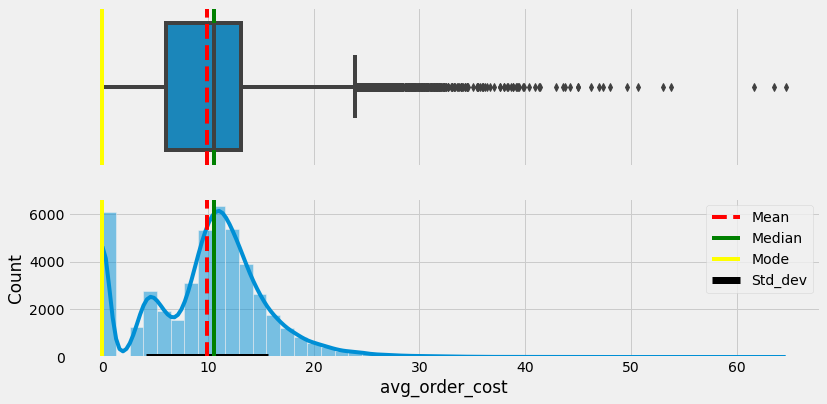

In [15]:
# Set subplots
f, (ax_box, ax_hist) = plt.subplots(2, sharex=True, figsize=(12, 6))

# Summary statistic calculation
mini=partners['avg_order_cost'].min()
maxi=partners['avg_order_cost'].max()
mean=partners['avg_order_cost'].mean()
median=partners['avg_order_cost'].median()
mode=partners['avg_order_cost'].mode().values[0]
rang=partners['avg_order_cost'].max()-partners['avg_order_cost'].min()
st_dev=partners['avg_order_cost'].std()
skew=partners['avg_order_cost'].skew()
kurt=partners['avg_order_cost'].kurtosis()
points = mean-st_dev, mean+st_dev

# Set boxplot
sns.boxplot(data=partners, x='avg_order_cost',ax=ax_box)
ax_box.axvline(mean, color='red', linestyle='--')
ax_box.axvline(median, color='green', linestyle='-')
ax_box.axvline(mode, color='yellow', linestyle='-')
ax_box.set(xlabel='')

# Set histogram
sns.histplot(data=partners, x='avg_order_cost', bins=50, ax=ax_hist, kde=True)
ax_hist.axvline(mean, color='red', linestyle='--', label="Mean")
ax_hist.axvline(median, color='green', linestyle='-', label="Median")
ax_hist.axvline(mode, color='yellow', linestyle='-', label="Mode")
ax_hist.hlines(0, points[0], points[1], linewidth=7, color='black', linestyle='-', label="Std_dev")
ax_hist.legend()

# Prin results
print('mean = {}\nmedian = {}\nmode = {}\nrange = {}\nstd_dev = {}\nskew = {}\nkurtosis = {}'.format(round(mean,2),
                                                                                                round(median,2),
                                                                                                round(mode,2),  
                                                                                                (round(mini,2),round(maxi,2),round(rang,2)),
                                                                                                round(st_dev,2),
                                                                                                round(skew,2),
                                                                                                round(kurt,2)
                                                                                                ))
plt.show()

Summary of **avg_order_cost**:
- value that has the highest frequency is 0 (around 6000 instancies), it means many orders costed nothing to theirs customers, probably they were part of promo actions, free gifts etc.;
- skewness +0.26 says **avg_order_cost** is negligibly biased towards increasing, but common rule if the skewness is between -0.5 and 0.5, the data are fairly symmetrical as what we can consider;
- kurtosis 1.49: extreme values and outliers are very likely to be present in avg_order_cost, that what we can clearly see  on boxplot graph (roughly above 24-25);
- most popular orders have cost around 9-13 with median 10.55;
- std_dev 5.79: low standard deviation indicates that values are clustered close to the mean, which is 9.9.

**7. What is the number of orders compared to connected time? Is there a correlation between the two?**

There are two common ways to perform bivariate analysis for numeric variables:

1. *Scatterplots*

2. *Correlation Coefficients*

Let's do both of them and explore relation between all metrics and then more detailed **orders_weekly** vs **connected_hours**.

But firstly it's necessary to examine metrics for outliers since it could influence a lot on correlation results.

In [16]:
# Create custom function to define limits
def outlier_threshold(df, col_name, q1_perc=0.01, q3_perc=0.99):
    """
    Given DataFrame, column name, q1_percentage and q3_percentage, function calculates low_limit and up_limit
    """
    
    quartile1 = df[col_name].quantile(q1_perc)
    quartile3 = df[col_name].quantile(q3_perc)
    interquantile_range = quartile3 - quartile1
    up_limit = quartile3 + 1.5*interquantile_range
    low_limit = quartile1 - 1.5*interquantile_range
    return up_limit, low_limit

# Create custom function to detect outliers
def check_outliers(df, col_name):
    low_limit, up_limit = outlier_threshold(df, col_name)
    if df[(df[col_name] > up_limit) | (df[col_name] < low_limit)].any(axis=None):
        return True
    else:
        return False

In [17]:
# Print results
print("Outliers in 'orders_weekly' column is : {}".format(check_outliers(partners, 'orders_weekly')))
print("Outliers in 'connected_hours' column is : {}".format(check_outliers(partners, 'connected_hours')))

Outliers in 'orders_weekly' column is : True
Outliers in 'connected_hours' column is : True


One way to work around it and visualise correlation of metrics well is to take logarithm transform of every variable to nullify the effect of outliers.

[]

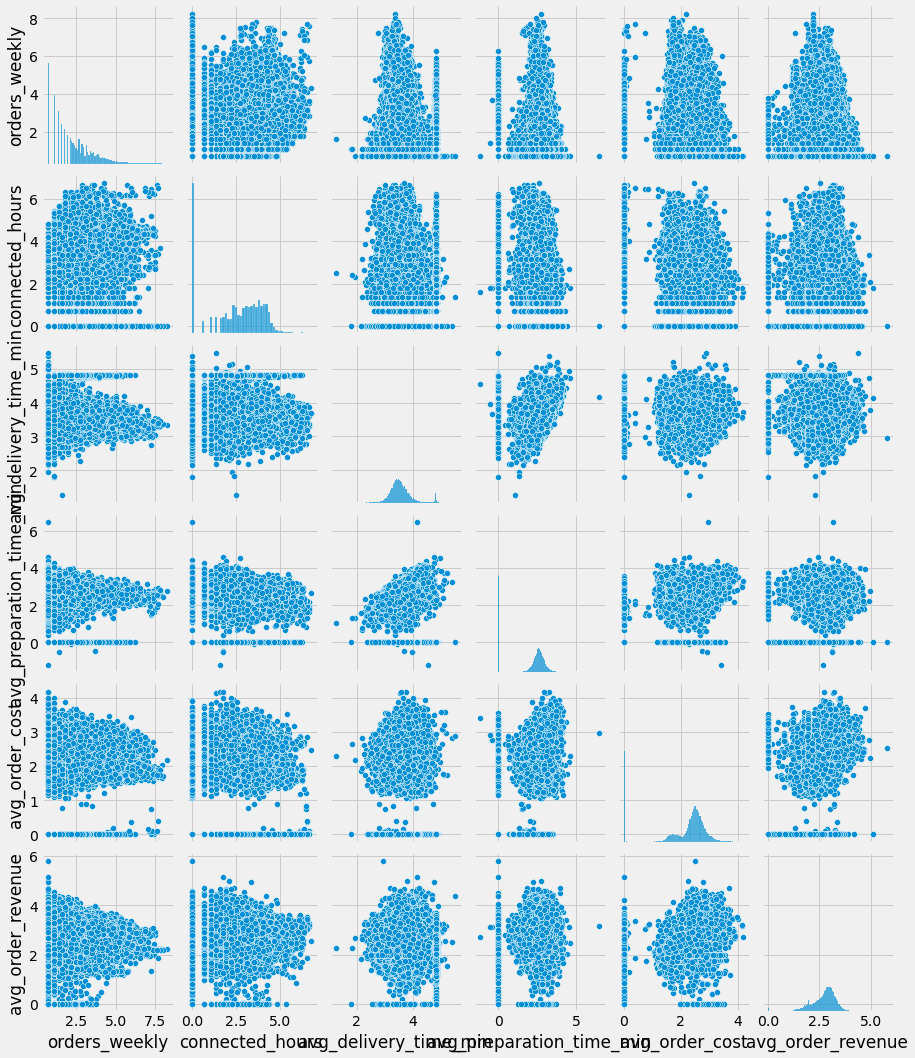

In [18]:
# Apply logorithm tranformation on selected variables
transformed = metrics_grouped.drop('partner_id', axis=1).apply(lambda x : np.log1p(x))

# Set pairplot
sns.pairplot(
    data=transformed, 
    aspect=.85)
plt.plot()

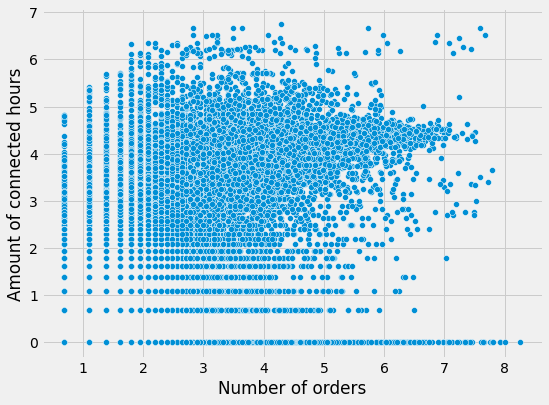

In [19]:
# Set scatterplot
plt.figure(figsize=(8, 6))
sns.scatterplot(x='orders_weekly', y='connected_hours', data=transformed)
plt.xlabel('Number of orders')
plt.ylabel('Amount of connected hours')
plt.show()

Correlation between number of orders and connected time is: 36.81 %




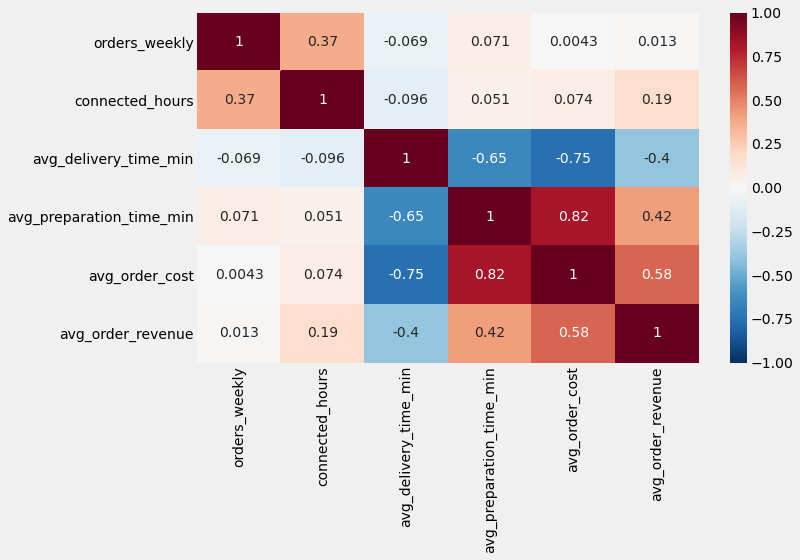

In [20]:
# Set correlation matrix
plt.figure(figsize=(10,6))
sns.heatmap(
    transformed.corr(),        
    cmap='RdBu_r', 
    annot=True, 
    vmin=-1, vmax=1)
plt.plot()


# Calculate correlation coficient between two measures
correlation = round(transformed['orders_weekly'].corr(transformed['connected_hours'])*100,2)

# Print result
print("Correlation between number of orders and connected time is:", correlation,"%")
print('\n')

**Conclusions:** Looking at the distribution on the scatterplot possible to see that there is not strong correlation between two measures. And with using of 'corr' Pandas method correlation is caculated around 36.81%, that could be considered as moderate.

**8. What are the differences in the metrics for Food vs Q-commerce?**

This task require to perform bivariate analysis *numeric variables vs categorical one*.
Let's build several plots to understand data relation better and make some conclusions.
I am going to use *bar, density and box plots* to explore distribution of metrics in terms of **vertical** dimension.

Moreover, in this section I will work with hypothesis testing. 
The null hypothesis is defined like *there is no significant difference between Food and Q-commerce partners in terms of metrics*.

I will do the hypothesis testing during the plotting of graphs.
Three functions for this taks:

- function for 2 sample Z-Test;
- function for 2 sample T-Test;
- function for plotting which uses the above mentioned two functions.

Both Z-test and T-test are presented here to qualify that they perform similarly.

In [21]:
# Create custom function to perform 2-sampled Z-Test
def TwoSampZ(X1, X2, sigma1, sigma2, N1, N2):
    
    '''
    Takes mean, standard deviation, and number of observations and returns p-value calculated for 2-sampled Z-Test
    '''
    ovr_sigma = np.sqrt(sigma1**2/N1 + sigma2**2/N2)
    z = (X1 - X2)/ovr_sigma
    pval = 2*(1 - stats.norm.cdf(np.abs(z)))
    
    return pval

# Create custom function to perform 2-sampled T-Test
def TwoSampT(X1, X2, sd1, sd2, n1, n2):
    '''
    Takes mean, standard deviation, and number of observations and returns p-value calculated for 2-sample T-Test
    '''
    ovr_sd = np.sqrt(sd1**2/n1 + sd2**2/n2)
    t = (X1 - X2)/ovr_sd
    df = n1+n2-2
    pval = 2*(1 - stats.t.cdf(np.abs(t),df))
    
    return pval

# Create custom function to plot data
def Bivariate_cont_cat(data, cont, cat, category1, category2):
    
    # Create 2 samples
    x1 = data[cont][data[cat]==category1][:]
    x2 = data[cont][data[cat]==category2][:]
  
    # Calculate descriptives
    n1, n2 = x1.shape[0], x2.shape[0]
    m1, m2 = x1.mean(), x2.mean()
    std1, std2 = x1.std(), x2.mean()

    # Calculate p-values
    t_p_val = TwoSampT(m1, m2, std1, std2, n1, n2)
    z_p_val = TwoSampZ(m1, m2, std1, std2, n1, n2)

    # Create pivot table
    table = pd.pivot_table(data=data, values=cont, columns=cat, aggfunc = np.mean)

    # Plotting
    plt.figure(figsize = (20,4), dpi=140)

    # Set barplot
    plt.subplot(1,3,1)
    sns.barplot([str(category1),str(category2)], [m1, m2])
    plt.ylabel('mean {}'.format(cont))
    plt.xlabel(cat)
    plt.title('t-test p-value = {} \n z-test p-value = {}\n {}\n'.format(t_p_val,
                                                                    z_p_val,
                                                                    table))
    
    # Set densityplot, category-wise distribution
    plt.subplot(1,3,2)
    sns.kdeplot(x1, shade= True, color='blue', label = 'Food')
    sns.kdeplot(x2, shade= False, color='green', label = 'Q-commerce', linewidth = 1)
    plt.title('categorical distribution')

    # Set boxplot
    plt.subplot(1,3,3)
    sns.boxplot(x=cat, y=cont, data=data)
    plt.title('categorical boxplot')

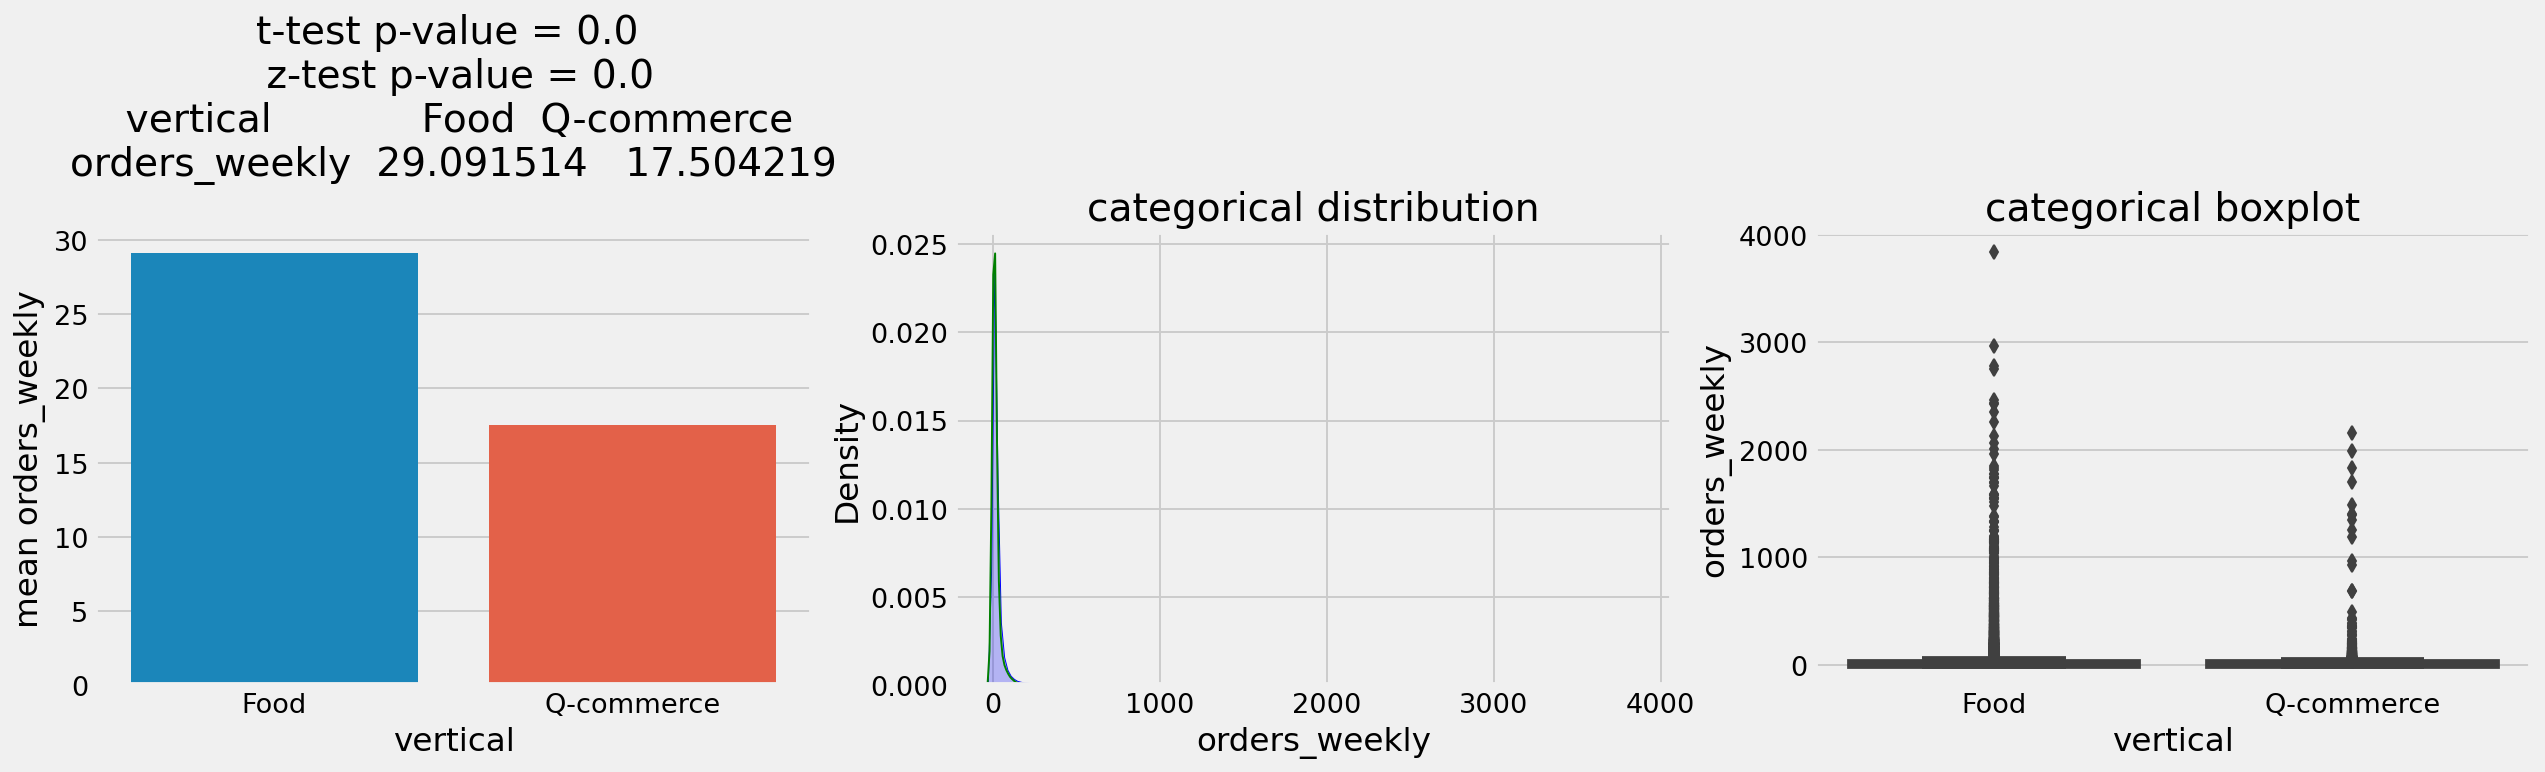

In [22]:
Bivariate_cont_cat(partners, 'orders_weekly', 'vertical', 'Food', 'Q-commerce')

**Inferences:**

- *Food* partners have more orders in average;
- p-value is < 0.05, null hypothesis is rejected, results are significant;
- densityplot shows very similar distribution;
- there are outliers on boxplot that effects on total results.

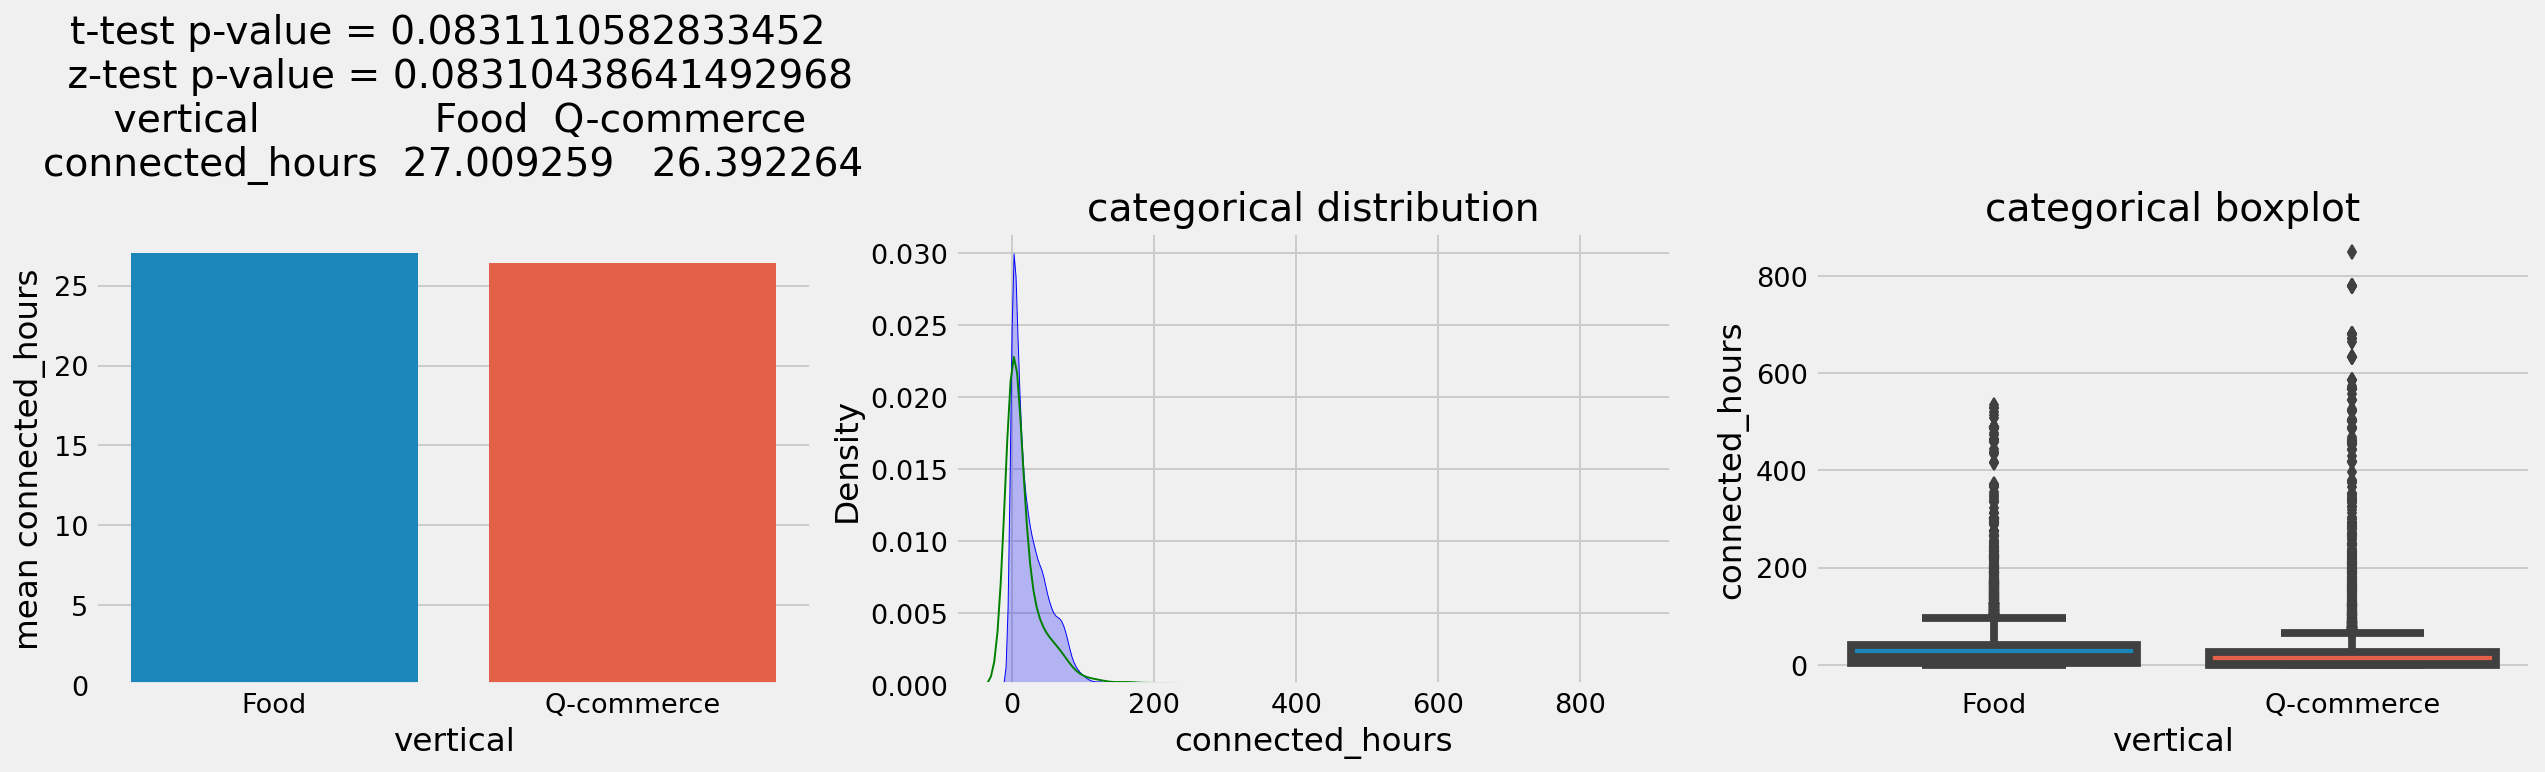

In [23]:
Bivariate_cont_cat(partners, 'connected_hours', 'vertical', 'Food', 'Q-commerce')

**Inferences:**

- two samples have more or less similar distribution;
- means of both subset are pretty close to each other, results are significant (p>0.05);
- Q-commerce subset has outliers with higher hours amount.

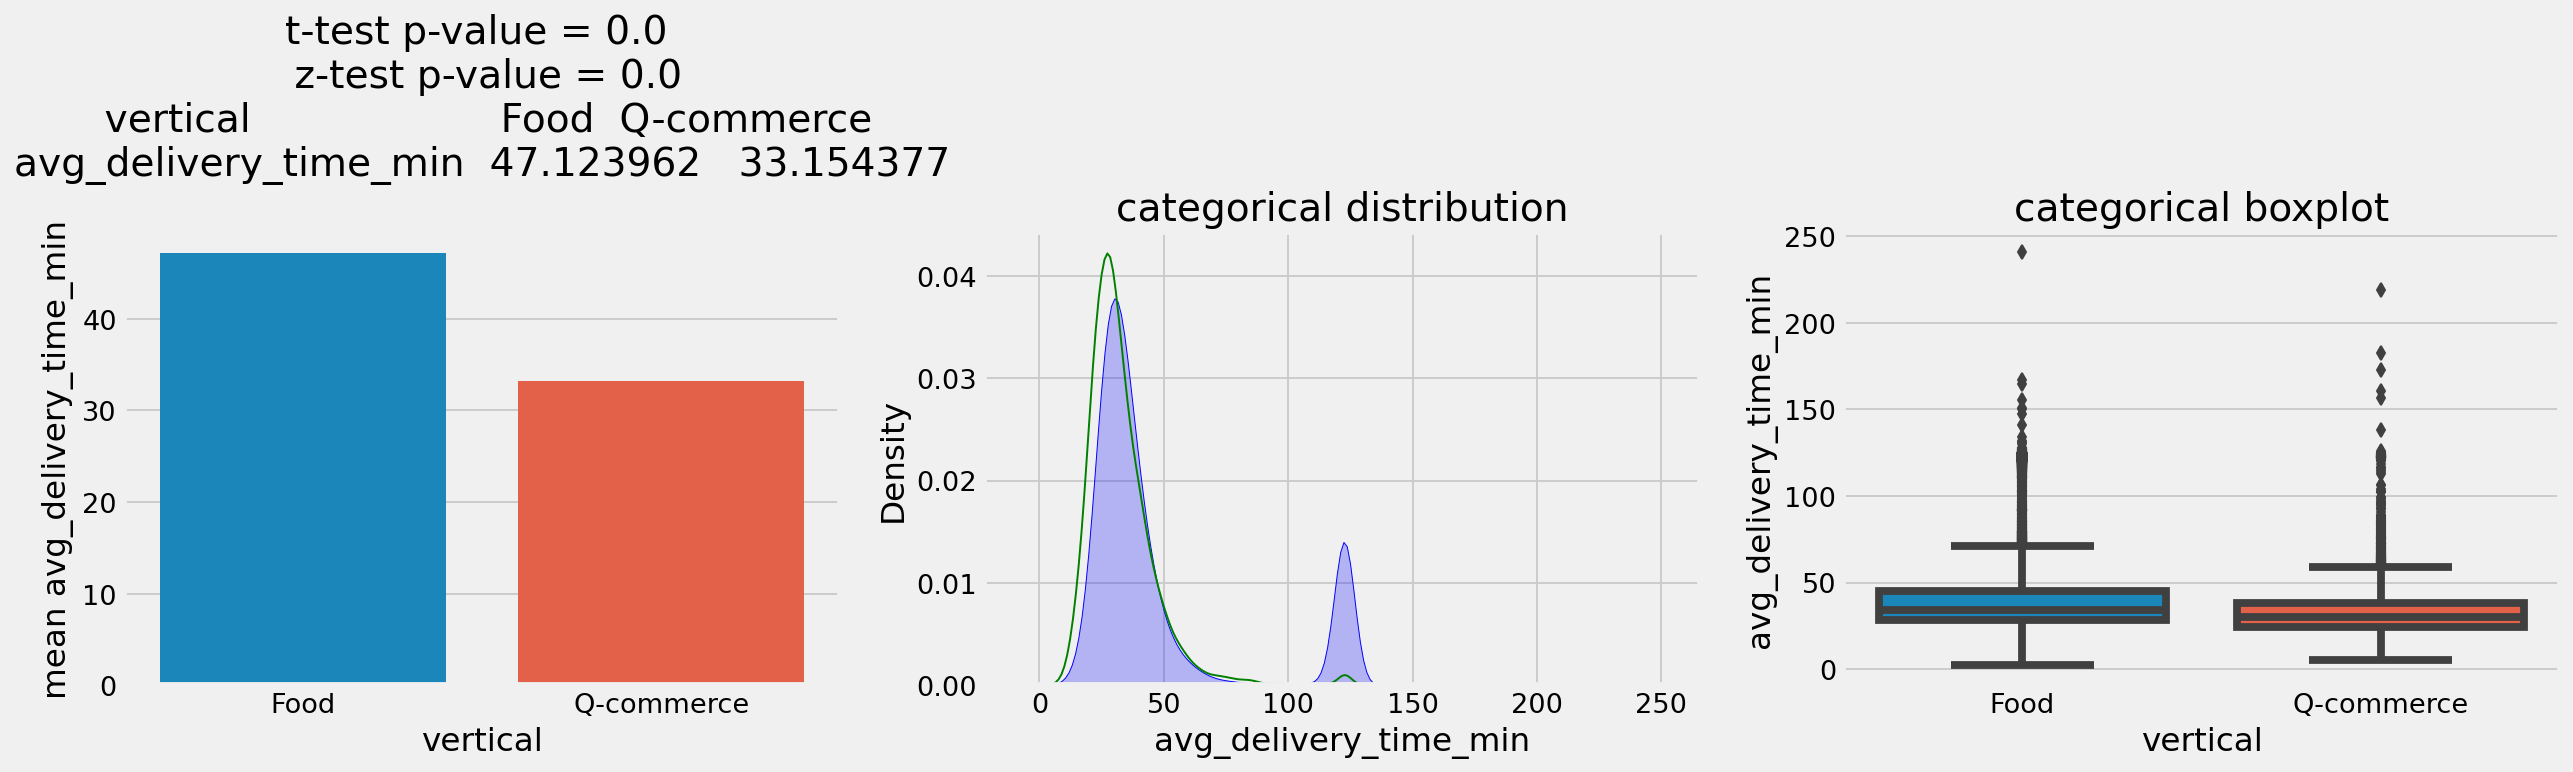

In [24]:
Bivariate_cont_cat(partners, 'avg_delivery_time_min', 'vertical', 'Food', 'Q-commerce')

**Inferences:**

- *Food* partners have significantly higher average delivery time;
- plots show there is much bigger number of partners in *Food* category who has average time between of 100 and 150 mins;
- p-value is < 0.05: reject null hypothesis;
- both sample have outliers that can impact on results.

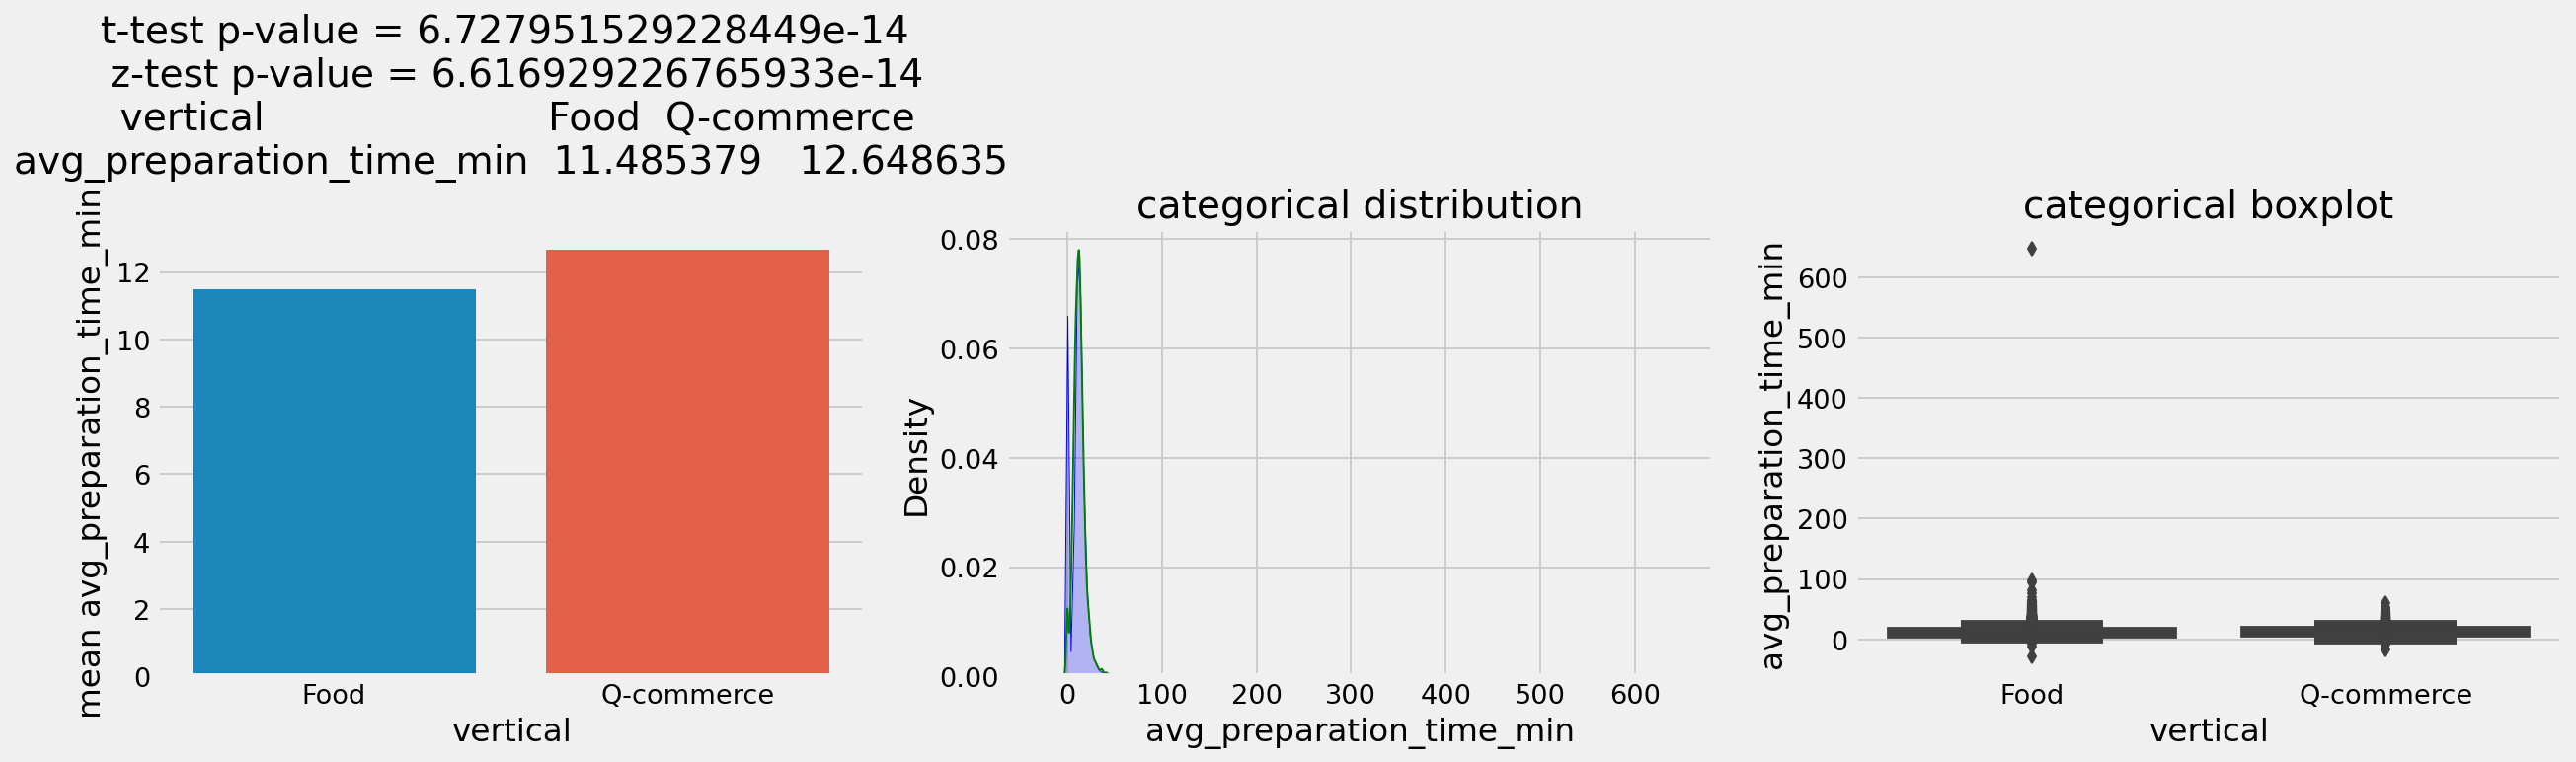

In [25]:
Bivariate_cont_cat(partners, 'avg_preparation_time_min', 'vertical', 'Food', 'Q-commerce')

**Inferences:**

- *Q-commerce* partners have slightly higher average preparation time;
- samples are significant different, p_value < 0.05;
- *Food* distribution shows many partners have close to 0 average preparation time;
- *Food* subset has one outlier who reflects a lot on mean result.

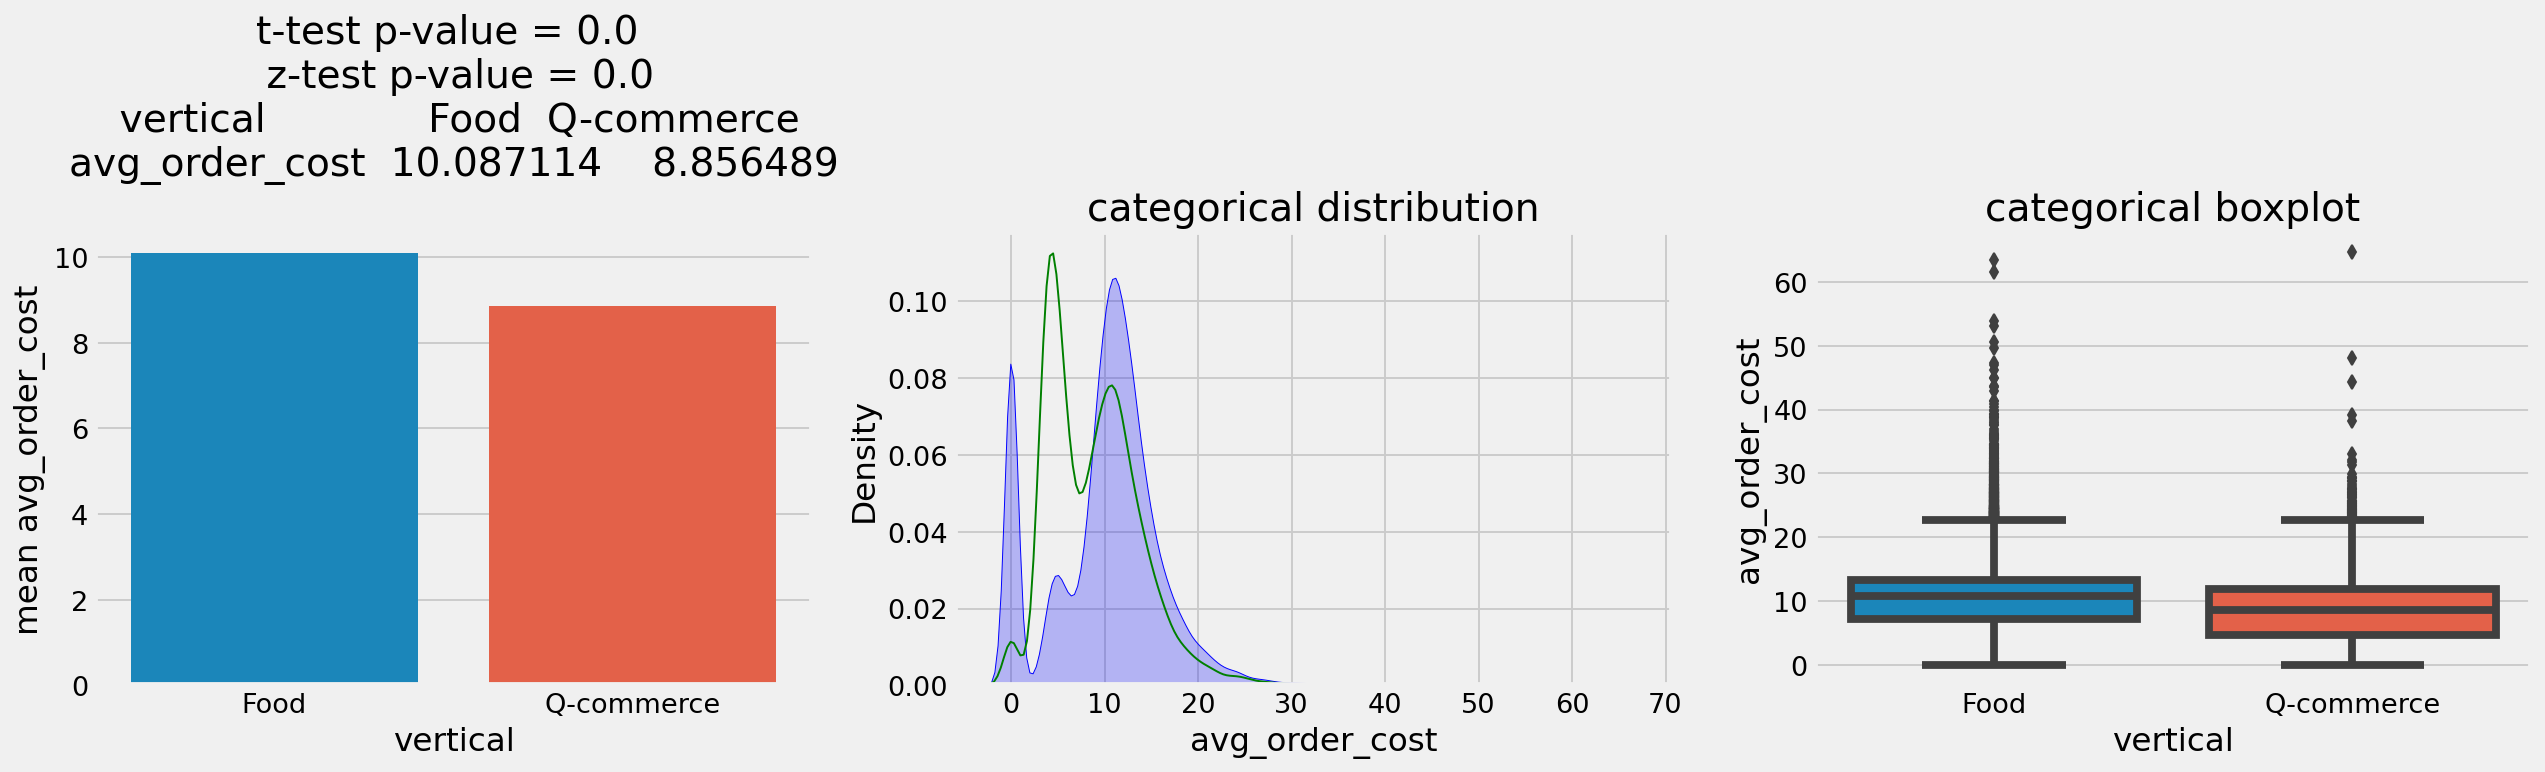

In [26]:
Bivariate_cont_cat(partners, 'avg_order_cost', 'vertical', 'Food', 'Q-commerce')

**Inferences:**

- *Food* partners have higher average order cost;
- results are significant, p_value < 0.05, reject null hypothesis;
- distributions vary, many *Food* partners have 0 cost orders, it can mean they perform promo actions, free gifts etc.;
- both subsets have many outliers.

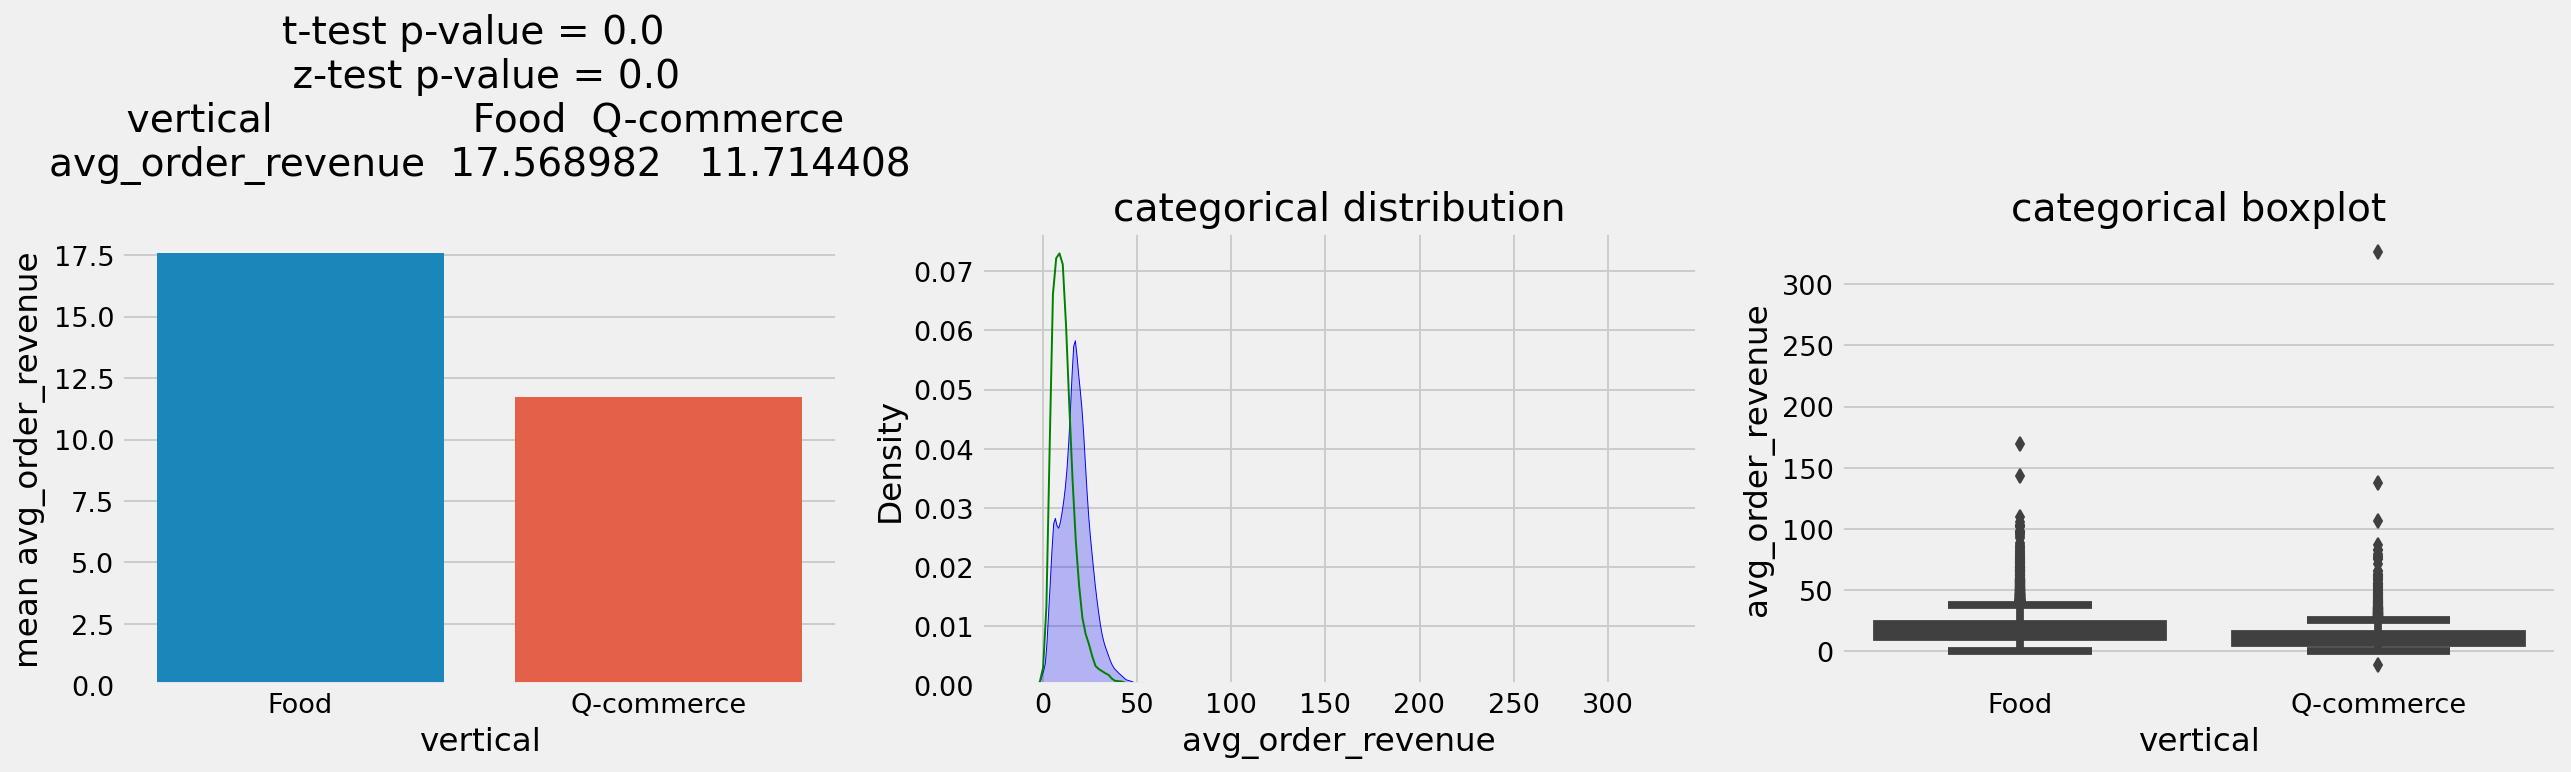

In [27]:
Bivariate_cont_cat(partners, 'avg_order_revenue', 'vertical', 'Food', 'Q-commerce')

**Inferences:**

- *Food* partners have significantly higher average order revenue, p_value < 0.05;
- *Q-commerce* subset has one outlier who reflets a lot on average result.

**9. Among all the possible combinations of dimensions (segments), which one has the highest number of partners?**

The decision is to group by all dimensions and apply 'size' method to get number of rows (since each row is record for one unique partner we are getting number of partners) for every possible combination of dimensions. Then sort result in descending order and select the top one.

In [28]:
# Groupby all dimension and get size of each combination
number_of_partners = partners.groupby(['vertical','business_segment','is_integrated','country'], 
                                              as_index=False).size()
# Rename column in more appropriate way
number_of_partners.rename(columns={'size':'number_of_partners'}, inplace=True)

# Print result
print("Combination of dimensions with the highest number of partners:")
print('\n', "-"*70,'\n') 
print(number_of_partners.sort_values('number_of_partners', ascending=False).head(1))

Combination of dimensions with the highest number of partners:

 ---------------------------------------------------------------------- 

   vertical business_segment  is_integrated country  number_of_partners
24     Food        Long Tail          False      ES               10297


**10. Summarize your findings in an executive summary.**






The dataset contains 46208 active partners.

Majority is represented by *Spanish* market (22183), that is double more than second lagest *Italian* (10840) and even triple bigger in comparison with *Ukraine* and *Portugal* (6808, 6377 accordingly). 

Most of partners belongs to *Long Tail* business segment (21273) that is three times ahead of the second in a row *Chain* segment (7529).

80% of all orders in dataset has been delivered by 21.37 % of partners. This observation confirms *Pareto principle* that roughly 80% of consequences come from 20% of causes.

The smallest average delivery time is in Portugues market (34.98%). That could make assumption the couriers job is performed more eefectively than in others regions. Things to explore further the reasons behind successful delivery process.

57.44 % of all orders has been delivered by integrated partners. Thing to investigate further is correlation between *"is_integrated"* status and list of metrics to get better understanding of influence when status is True.

The detailed observation of *avg_order_cost* metric displays most frequent value is 0, it could mean many partners (*Food* category mostly) run promotions or grant some orders as gifts.

The correlation between *orders_weekly* and *connected_hours* is 36.81 %, it can be considered as moderate. 
Quick review of all metrics shows the strongest dependencies (positive correlation) between *avg_preperation_time* and *avg_order_cost*, the reason of it could be in the fact that most expensive orders are also the most difficult to prepare and take more time to be done.

Section with comparison of two categories *Food* vs *Q-commerce* shows all metrics have many outliers. And even that Food partners have in average higher results in most of metrics (some could be considered as positive *avg_order_revenue*, some as negative *avg_delivered _time*) those results are under impact of outliers.

Quick observation of metric distributions shows they vary in ranges and for futher purposes to apply machine learning distanced-based (clustering) or gradient descend based (regressions) algorythms, it's necessary to perform feature scaling technique (like MinMax Scaler for example). 

# Task 2

**1. Which combination of dimensions (segments) has the highest business value in your opinion for Glovo and why?**

To solve this taks aggregate all measures by every possible combination of dimensions, create additional measures and explore them to find highest values in dataset. 

In [29]:
# Custom function to calculate weighted average
wm = lambda x: np.average(x, weights=partners.loc[x.index, "orders_weekly"])

# Aggregate all measures by each dimensions combination
combos = partners.groupby(['country','business_segment','vertical','is_integrated'],as_index=False).agg(
                                                                    {
                                                                       'partner_id': pd.Series.nunique,
                                                                       'orders_weekly':'sum', 
                                                                       'connected_hours':'sum', 
                                                                       'avg_delivery_time_min':wm, 
                                                                       'avg_preparation_time_min':wm,
                                                                       'avg_order_cost':wm,
                                                                       'avg_order_revenue':wm,
                                                                       }
                                                                   )
    
# Rename column in more appropriate way      
combos.rename(columns={'partner_id':'num_partners'}, inplace=True)
combos.head()

,country,business_segment,vertical,is_integrated,num_partners,orders_weekly,connected_hours,avg_delivery_time_min,avg_preparation_time_min,avg_order_cost,avg_order_revenue
0,ES,Big Chain,Food,False,270,9540.0,13543,33.367876,10.834982,11.251835,15.480613
1,ES,Big Chain,Food,True,2161,206255.0,62760,44.054751,9.186179,10.407087,14.922463
2,ES,Chain,Food,False,2003,52120.0,64778,35.386156,12.304347,11.882931,20.486766
3,ES,Chain,Food,True,1402,76876.0,62755,36.547239,12.154076,11.420697,18.736465
4,ES,Local Hero,Food,False,2054,70717.0,66643,38.410203,11.150664,10.871773,21.697229


In [30]:
# Generate new additional measures of effectiveness
combos['avg_order_profit'] = combos['avg_order_revenue'] - combos['avg_order_cost']
combos['total_profit'] = (combos['orders_weekly']*combos['avg_order_profit']).round(0).astype('int')

# Sort dataset by chosen metrics to display top ranked
top_three_profit = combos.sort_values('total_profit', ascending=False).head(3)
top_three_avg_profit = combos.sort_values('avg_order_profit', ascending=False).head(3)
top_three_orders = combos.sort_values('orders_weekly', ascending=False).head(3)

I decided to extend the task and performed observation of combinations with top three results in several chosen metrics.

The first metric is **total profit** that is the most important for every business to exist and have further progress.
The most ranked combinations in this group belong to Spanish market and have *Food* category in 'vertical' dimension. The best one is integrated and belongs to *Big Chain* business segment. There is huge amount of orders here, it means this segment is very active and generates a lot of interactions with clients. Then suggestion for this combination would be increasing number of partners in the same segment.

In [31]:
top_three_profit

,country,business_segment,vertical,is_integrated,num_partners,orders_weekly,connected_hours,avg_delivery_time_min,avg_preparation_time_min,avg_order_cost,avg_order_revenue,avg_order_profit,total_profit
1,ES,Big Chain,Food,True,2161,206255.0,62760,44.054751,9.186179,10.407087,14.922463,4.515376,931319
6,ES,Long Tail,Food,False,10297,92731.0,221660,45.709507,10.637117,10.571533,19.256016,8.684483,805321
4,ES,Local Hero,Food,False,2054,70717.0,66643,38.410203,11.150664,10.871773,21.697229,10.825456,765544


Next metrics for observation is **average profit per order** and the champions in that measure are partners in Italian market who is integrated, belongs to *Food* category in 'vertical' dimension, and have *Long Tail* business segment. Unfortunately they are few, 19 only, so suggestion here is the same: firstly try to increase the number of partners. 

But if explore two next most ranked combinations with bigger number of partners it can be defined they are pretty similar, both in Spanish market, *Food* vertical, *Local Hero* business segment and only difference in integrated status. For both combinations one more suggestion could be promotion those partners to increase number of orders with highest average profit.

In [32]:
top_three_avg_profit

,country,business_segment,vertical,is_integrated,num_partners,orders_weekly,connected_hours,avg_delivery_time_min,avg_preparation_time_min,avg_order_cost,avg_order_revenue,avg_order_profit,total_profit
19,IT,Long Tail,Food,True,19,140.0,185,29.378810,10.888588,13.594227,29.070969,15.476742,2167
4,ES,Local Hero,Food,False,2054,70717.0,66643,38.410203,11.150664,10.871773,21.697229,10.825456,765544
5,ES,Local Hero,Food,True,295,12769.0,8928,37.534670,11.356433,10.865673,21.674037,10.808364,138012


Third chosen metric is **total number of orders** and results here show that in three countries: Spain, Ukrain and Italy, the biggest order numbers are generated by integrated partners from *Big Chain* business segment in *Food* category by 'vertical'. The best one combo is also the winner of first observed group **(total profit)**, so suggestion here stays the same, look for the partners in the same segment since they have a lot of customers, but also it can be expected to get even more orders with special promo actions. As it was mentioned above those partners are very popular and customers tend to search for their goods. 

In [33]:
top_three_orders

,country,business_segment,vertical,is_integrated,num_partners,orders_weekly,connected_hours,avg_delivery_time_min,avg_preparation_time_min,avg_order_cost,avg_order_revenue,avg_order_profit,total_profit
1,ES,Big Chain,Food,True,2161,206255.0,62760,44.054751,9.186179,10.407087,14.922463,4.515376,931319
35,UA,Big Chain,Food,True,88,106256.0,3215,27.596975,12.143697,5.322507,7.769756,2.447249,260035
13,IT,Big Chain,Food,True,493,102013.0,24636,28.014042,12.859083,13.618353,16.783116,3.164763,322847


**2. We want to run an experiment in Spain (ES). Create two groups of partners that behave similarly in terms of metrics. 
Make sure all types of partners are represented.**

To perform the task apply unsupervise machine learning technique for hehavioral segmentation and identify clusters of data objects in a dataset.
Then take one cluster, check the presence of all possible types of partners, and split it onto two groups: control and test, for further purposes in experiment. 

In [34]:
# Select Spanish partners only
spain = partners[partners['country']=="ES"].reset_index(drop=True)

# Select columns with metrics 
spain_metrics = spain[['orders_weekly','connected_hours','avg_delivery_time_min','avg_preparation_time_min',
                       'avg_order_cost','avg_order_revenue']]

I am going to use K-means clustering algorythm that is example of distance-based ones. It needs to consider all features on an even playing field. That means the values for all features must be transformed to the same scale.

In [35]:
# Scale metric columns
scaler = MinMaxScaler()
spain_scaled = scaler.fit_transform(spain_metrics)

# Print result
print(spain_scaled)

[[4.63821892e-04 2.12264151e-02 6.66772127e-02 3.24531449e-01
  9.25921371e-02 1.34134793e-01]
 [1.02040816e-02 0.00000000e+00 1.19220466e-01 3.63636678e-01
  2.14142326e-01 1.81327441e-01]
 [1.11317254e-02 4.24528302e-02 1.20819426e-01 3.06107582e-01
  2.42322318e-01 2.05321044e-01]
 ...
 [0.00000000e+00 0.00000000e+00 7.92533418e-02 3.43789708e-01
  2.61553626e-01 4.98603602e-01]
 [0.00000000e+00 4.71698113e-03 6.40670727e-02 2.86292884e-01
  1.91899119e-01 1.38460583e-01]
 [0.00000000e+00 8.25471698e-03 1.22834770e-01 2.84069250e-01
  2.25812590e-01 1.60955222e-01]]


Next step is to define number of cluster we need to split our dataset on. 
There are two most common methods are used to evaluate the appropriate number of clusters:

- *the elbow method*
- *the silhouette coefficient*

These are often used as complementary evaluation techniques rather than one being preferred over the other. 
To perform the **elbow method**, need to run several models, increment k (number of clusters) with each iteration, and record the sum of the squared error (evaluation metric).

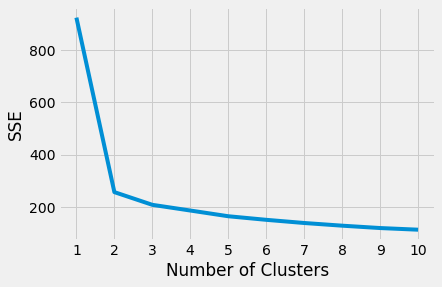

In [36]:
# Set parameters of the model
kmeans_kwargs = {

    "init": "k-means++",
    "n_init": 10,
    "max_iter": 300,
 }

# Holds the SSE values for each k
sse = []

for k in range(1, 11):
    kmeans = KMeans(n_clusters=k, **kmeans_kwargs)
    kmeans.fit(spain_scaled)
    sse.append(kmeans.inertia_)
    
# Plot result    
plt.style.use("fivethirtyeight")
plt.plot(range(1, 11), sse)
plt.xticks(range(1, 11))
plt.xlabel("Number of Clusters")
plt.ylabel("SSE")
plt.show()

There is a spot where the SSE curve starts to bend known as the elbow point. The x-value of this point is a reasonable trade-off between error and number of clusters. The given elbow is located at x=2.

Determining the elbow point in the SSE curve isn’t always straightforward, then Python package **kneed** can be used to identify the elbow point programmatically.

In [37]:
kl = KneeLocator(
     range(1, 11), sse, curve="convex", direction="decreasing"
 )

kl.elbow

2

The **silhouette coefficient** is a measure of cluster cohesion and separation. It quantifies how well a data point fits into its assigned cluster based on two factors:

- *how close the data point is to other points in the cluster*
- *how far away the data point is from points in other clusters*

Silhouette coefficient values range between -1 and 1. Larger numbers indicate that samples are closer to their clusters than they are to other clusters.

Loop through values of k again. This time, instead of computing SSE, compute the silhouette coefficient.

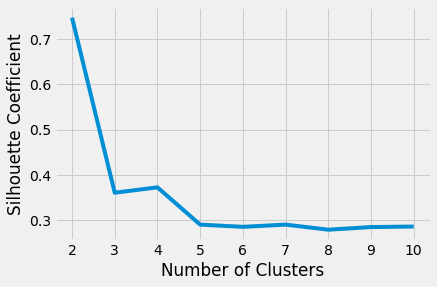

In [38]:
# Holds the silhouette coefficients for each k
silhouette_coefficients = []

# Start at 2 clusters for silhouette coefficient
for k in range(2, 11):
    kmeans = KMeans(n_clusters=k, **kmeans_kwargs)
    kmeans.fit(spain_scaled)
    score = silhouette_score(spain_scaled, kmeans.labels_)
    silhouette_coefficients.append(score)

# Plot result
plt.style.use("fivethirtyeight")
plt.plot(range(2, 11), silhouette_coefficients)
plt.xticks(range(2, 11))
plt.xlabel("Number of Clusters")
plt.ylabel("Silhouette Coefficient")
plt.show()

All three applied method to determine correct number of clusters shows that 2 is a right choice.

In [39]:
# Run the algorythm
kmeans = KMeans(n_clusters=2, **kmeans_kwargs)

# Predict clusters
clusters = kmeans.fit_predict(spain_scaled)

# Save cluster labels and number of istances
unique, counts = np.unique(clusters, return_counts=True)

# Print result
print(dict(zip(unique, counts)))

# Assign the labels to each partner
spain["label"] = clusters

{0: 18773, 1: 3410}


I am going to check the all possible combinations of dimensions to be sure having all types of partners for both clusters.

In [40]:
# Print names of all possible segments
print(spain['business_segment'].unique())
print('\n')

# Print number of all combinations and types of partners for cluster 0
print(spain[spain['label']==0].groupby(['vertical', 'business_segment', 'is_integrated',
       'country'], as_index=False).size())
print('-'*50,'\n')

# Print number of all combinations and types of partners for cluster 1
print(spain[spain['label']==1].groupby(['vertical', 'business_segment', 'is_integrated',
       'country'], as_index=False).size())

['Local Hero' 'Chain' 'Long Tail' 'Q-Commerce' 'Big Chain' 'Sidekick']


      vertical business_segment  is_integrated country  size
0         Food        Big Chain          False      ES   227
1         Food        Big Chain           True      ES   837
2         Food            Chain          False      ES  1862
3         Food            Chain           True      ES  1269
4         Food       Local Hero          False      ES  1834
5         Food       Local Hero           True      ES   263
6         Food        Long Tail          False      ES  8965
7         Food        Long Tail           True      ES   303
8         Food         Sidekick          False      ES   537
9         Food         Sidekick           True      ES   176
10  Q-commerce       Q-Commerce          False      ES   853
11  Q-commerce       Q-Commerce           True      ES  1647
-------------------------------------------------- 

      vertical business_segment  is_integrated country  size
0         Food      

As it's possible to see all types are presented in new dataset, that is ready to be splitted for experiment.
To perform selection and assigning the *control* & *test* groups use numpy funtion **random.binominal**, that draws samples from a binomial distribution.

In [54]:
# Count shape of distribution
first_cluster = spain[spain['label']==0].copy()
second_cluster = spain[spain['label']==1].copy()

length0 = first_cluster.shape[0]
length1 = second_cluster.shape[0]

# Apply binominal half by half
first_cluster['label'] = np.random.binomial(1, .5, length0)
second_cluster['label'] = np.random.binomial(1, .5, length1)

# Replace numeric lables with text ones
spain = pd.concat([first_cluster, second_cluster], axis=0, ignore_index=True)
spain['label'] = spain['label'].replace([0,1], ['Control','Test'], regex=True)

# Print percentage of presence
print(spain['label'].value_counts(normalize=True)*100)
print('\n')

# Print subset of dataframe
print(spain.head())

Test       50.484605
Control    49.515395
Name: label, dtype: float64


   partner_id vertical business_segment  is_integrated country  orders_weekly  \
0      247635     Food            Chain           True      ES           23.0   
1      472910     Food        Long Tail          False      ES           13.0   
2     1142860     Food            Chain          False      ES            9.0   
3     1316935     Food       Local Hero           True      ES           61.0   
4     1941610     Food            Chain          False      ES          116.0   

   connected_hours  avg_delivery_time_min  avg_preparation_time_min  \
0                0              33.005072                 18.019130   
1               37              36.270513                 18.561795   
2                0              32.424074                 13.044444   
3                4              39.166940                 18.953383   
4               42              38.862213                 13.957626   

   avg_order_c